# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
!pip install networkx==2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [6]:
edges = [tuple(x) for x in data.values.tolist()]

In [7]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [8]:
A = list(nx.connected_component_subgraphs(B))[0]

In [9]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


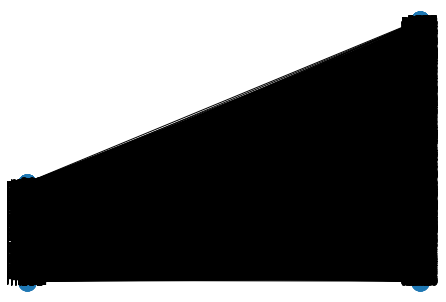

In [10]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [11]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [12]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [13]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [14]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [15]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

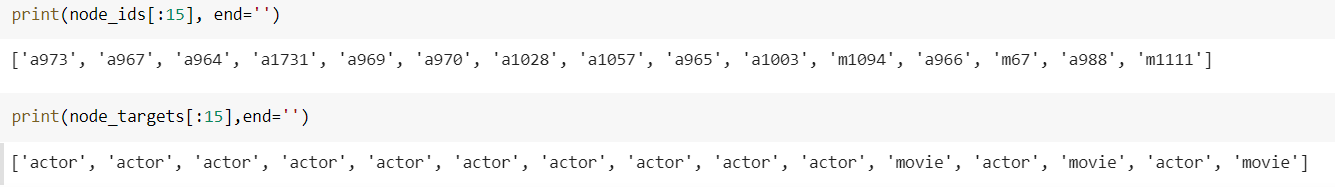

In [16]:
def data_split(node_ids,node_targets,node_embeddings):
  actor_nodes,movie_nodes=[],[]
  actor_embeddings,movie_embeddings=[],[]
  for i in range(len(node_ids)):
    if 'm' in node_targets[i]:
      movie_nodes.append(node_ids[i])
      movie_embeddings.append(node_embeddings[i])
    else:
      actor_nodes.append(node_ids[i])  
      actor_embeddings.append(node_embeddings[i])
  return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

In [17]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [18]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [19]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [20]:
def cost1(graph,number_of_clusters):
  max_con = len(max(nx.connected_components(graph)))
  no_nodes = graph.number_of_nodes()
  cost1 = (1/number_of_clusters) * (max_con/no_nodes)
  return cost1

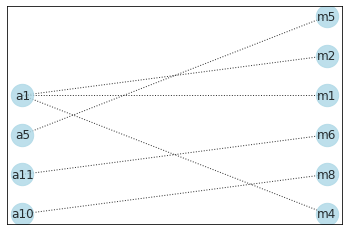

In [21]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [22]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [23]:
def cost2(graph,number_of_clusters):
  degrees = graph.degree()
  deg_sum, mov_nodes = 0,0
  for i in degrees:
    if 'a' in i[0]:
      deg_sum += i[1]
    else:
      mov_nodes += 1
  cost2 = (1/number_of_clusters) * (deg_sum/mov_nodes)
  return cost2

<font color='cyan'>Grader function - 4</font>

In [24]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='blue'>Grouping similar actors</font>

In [25]:
from sklearn.cluster import KMeans

In [26]:
cost_value={}
for clu in [3,5,10,50,200,300]:
  cost_1=0
  cost_2=0
  label=[]
  algo = KMeans(n_clusters=clu)
  algo.fit(actor_embeddings) 
  label=algo.labels_
  for i in range(clu):
    G1=nx.Graph()  
    label_divi=[]
    k=[index for index, value in enumerate(label) if value == i]
    label_divi=[actor_nodes[l] for l in k]
    for node in label_divi:
      sub_graph1=nx.ego_graph(B,node)
      G1.add_nodes_from(sub_graph1.nodes) 
      G1.add_edges_from(sub_graph1.edges()) 
    cst1=cost1(G1,clu)
    cost_1+=cst1 
    cst2=cost2(G1,clu) 
    cost_2+=cst2
  value=cost_1*cost_2 
  cost_value[clu]=value   

In [34]:
optimal_clu_no = max(cost_value, key=cost_value.get) 
print("optimal cluster number = ",optimal_clu_no)

optimal cluster number =  3


In [35]:
model= KMeans(n_clusters=optimal_clu_no)
model.fit(actor_embeddings)
label=model.labels_

In [36]:
node_cluster={}
for i in range(optimal_clu_no):
  k=[index for index, value in enumerate(label) if value == i]  
  label_divi=[actor_nodes[l] for l in k]
  for node in label_divi:
    node_cluster[node]=i

In [42]:
node_cluster['a1037']

2

<font color='blue'>Displaying similar actor clusters</font>

In [43]:
from sklearn.manifold import TSNE
trans = TSNE(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

In [64]:
actor_embeddings_2d[:,0].shape

(3411,)

Text(0.5, 1.0, 'TSNE 2D visualization of actor embeddings')

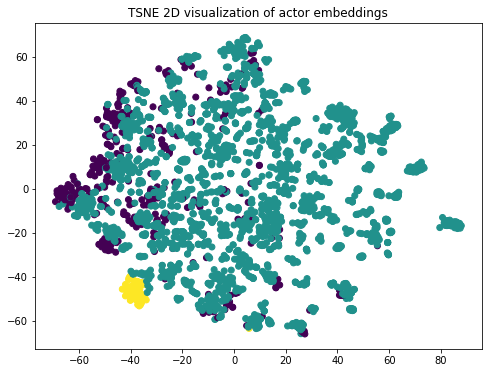

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6)) 
plt.scatter(actor_embeddings_2d[:,0], actor_embeddings_2d[:,1], c=model.labels_.astype(float))
plt.title('TSNE 2D visualization of actor embeddings')

<font color='blue'>Grouping similar movies</font>

In [65]:
def cost2(graph,number_of_clusters):
  degrees = graph.degree()
  deg_sum, mov_nodes = 0,0
  for i in degrees:
    if 'm' in i[0]:
      deg_sum += i[1]
    else:
      mov_nodes += 1
  cost2 = (1/number_of_clusters) * (deg_sum/mov_nodes)
  return cost2

In [66]:
cost_value={}
for clu in [3,5,10,50,200,300]:
  cost_1=0
  cost_2=0
  label=[]
  algo = KMeans(n_clusters=clu)
  algo.fit(movie_embeddings) 
  label=algo.labels_
  for i in range(clu):
    G1=nx.Graph()  
    label_divi=[]
    k=[index for index, value in enumerate(label) if value == i]
    label_divi=[movie_nodes[l] for l in k]
    for node in label_divi:
      sub_graph1=nx.ego_graph(B,node)
      G1.add_nodes_from(sub_graph1.nodes) 
      G1.add_edges_from(sub_graph1.edges()) 
    cst1=cost1(G1,clu)
    cost_1+=cst1 
    cst2=cost2(G1,clu) 
    cost_2+=cst2
  value=cost_1*cost_2 
  cost_value[clu]=value   

In [68]:
optimal_clu_no = max(cost_value, key=cost_value.get) 
print("optimal cluster number = ",optimal_clu_no)

optimal cluster number =  3


In [70]:
model= KMeans(n_clusters=optimal_clu_no)
model.fit(movie_embeddings)
label=model.labels_

In [82]:
node_cluster={}
for i in range(optimal_clu_no):
  k=[index for index, value in enumerate(label) if value == i]  
  label_divi=[movie_nodes[l] for l in k]
  for node in label_divi:
    node_cluster[node]=i

In [90]:
node_cluster['m1261']

2

<font color='blue'>Displaying similar movie clusters</font>

In [92]:
from sklearn.manifold import TSNE
trans = TSNE(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

In [93]:
movie_embeddings_2d[:,0].shape

(1292,)

Text(0.5, 1.0, 'TSNE 2D visualization of actor embeddings')

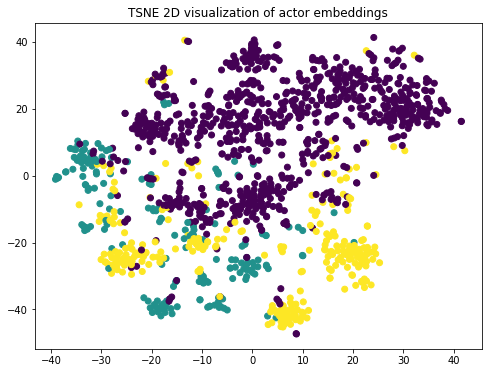

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6)) 
plt.scatter(movie_embeddings_2d[:,0], movie_embeddings_2d[:,1], c=model.labels_.astype(float))
plt.title('TSNE 2D visualization of actor embeddings')